# Playground ⛹️
- a "battlefield" - a place to experiment and test things.

Load dataset, augment data, print samples, etc.

In [8]:
# Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.preprocessing import Preprocessing
import numpy as np


In [9]:
# Import custom preprocessing library
prep = Preprocessing()
train_set = prep.download(split='train', download=False)

c:\Users\marco\.conda\envs\exp\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [10]:
# Print random audio sample
prep.print_raw_sample(np.random.randint(len(train_set)), train_set)

+------ Printing info for sample [22126] ------+
- Waveform is a Tensor of size [1, 229440], type=torch.float32
- Sample rate: 16000
- Transcript: TALKED ABOUT BUT NOT IN A HARMFUL WAY AND ...
- Speaker id: 7067
- Chapter id: 76047
- Utterance id: 27
+---------------------------------------+


In [11]:
# Create data loader
train_loader = DataLoader(dataset=train_set,
                          batch_size=16,
                          shuffle=True,
                          collate_fn=lambda x: prep.preprocess(x, "train"))



In [12]:
# Inspect batch of data
prep.print_loader_info(train_loader)

+------ Dataloader length: 28539 ------+
# Batches: 1784
Spectogram shape: [16, 1, 128, 1349]
Label shape: [16, 274]
Mel length (length of each spectogram): [603, 549, 493, 602, 519, 598] ...
Idx length (length of each label): [274, 177, 225, 215, 211, 210] ...
+------------------------------------+


In [13]:
torch.cuda.is_available()

False

Import custom models and neural layers, and test them on sample data.

In [6]:
from models.deep_speech_2 import MyLayerNorm, MySkipCNN, MyBiGRU, MyDeepSpeech
from torch.nn import Conv2d, Linear

#layer_norm = MyLayerNorm(n_bins=128)
cnn = Conv2d(1, 32, 3, stride=2, padding=1)
skip_cnn = MySkipCNN(32, 32, kernel=3, stride=1, drop_rate=0.5, n_bins=64)
fc = Linear(2048, 512)

bigru_1 = MyBiGRU(512, 512, 0.5, True)
bigru_2 = MyBiGRU(1024, 512, 0.5, True)

deep_speech = MyDeepSpeech(3, 5, 512, 29, 128)

In [7]:
# Check shapes layer by layer
for idx, data in enumerate(train_loader):
    
    # batch of data to play with
    spec = data[0]

    #### layer norm ####
    # print(f"Shape before: {spec.shape}")
    # out = layer_norm(spec)
    # print(f"Shape after: {out.shape}")
    
    # Skip cnn
    print(f"Shape before: {spec.shape}") # [16, 1, 128, 1315]
    out = cnn(spec)
    out = skip_cnn(out)

    sizes = out.shape
    print(f"Shape after CNN and SkipCNN: {sizes}") # [16, 32, 64, 658]
    
    out = out.view(sizes[0], sizes[1]*sizes[2], sizes[3])
    print(f"Shape after view: {out.shape}") # [16, 2048, 658]

    out = out.transpose(1, 2)
    print(f"Shape after tranpose: {out.shape}") # [16, 658, 2048]

    out = fc(out)
    print(f"Shape after linear layer: {out.shape}") # [16, 648, 512]

    out = bigru_1(out)
    print(f"Shape after bigru 1: {out.shape}")  # [16, 648, 1024]
    
    out = bigru_2(out)
    print(f"Shape after bigru 2: {out.shape}")  # [16, 648, 1024]

    out = Linear(1024, 512)(out)
    out = nn.GELU()(out)
    out = nn.Dropout(0.5)(out)
    out = nn.Linear(512, 27)(out)
    print(f"Shape after final linear classifier: {out.shape}") # [16, 639, 27]
    break

Shape before: torch.Size([16, 1, 128, 1265])
Shape after CNN and SkipCNN: torch.Size([16, 32, 64, 633])
Shape after view: torch.Size([16, 2048, 633])
Shape after tranpose: torch.Size([16, 633, 2048])
Shape after linear layer: torch.Size([16, 633, 512])
Shape after bigru 1: torch.Size([16, 633, 1024])
Shape after bigru 2: torch.Size([16, 633, 1024])
Shape after final linear classifier: torch.Size([16, 633, 27])


In [8]:
# Check deep speech model
for idx, data in enumerate(train_loader):
    spec = data[0]

    print(f"Input shape: {spec.shape}")
    out = deep_speech(spec)
    print(f"Output shape: {out.shape}")
    break

Input shape: torch.Size([16, 1, 128, 1305])
Deep: torch.Size([16, 32, 64, 653])
Deep: torch.Size([16, 32, 64, 653])
Deep: torch.Size([16, 653, 512])
After RNN block: torch.Size([16, 653, 1024])
Final: torch.Size([16, 653, 29])
Output shape: torch.Size([16, 653, 29])


In [4]:
! nvidia-smi

Fri Mar 29 10:28:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.70                 Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   26C    P0              23W / 105W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import torch
torch.zeros(1).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [7]:
import torch
import sys

print(sys.version)
print(torch.version.cuda)

3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]
None


Wandb - dummy script to log accuracy and loss

In [3]:
1305 // 2

652

In [9]:
! pip install wandb

In [10]:
! wandb login 33a194fab1b28225adfa0561f9a0dcbae4adff8b

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\marco\.netrc


In [11]:
import wandb
import random

# Init
wandb.init(
    project="asr_librispeech",

    # hyperparams to track
    config= {
        "lr": 0.001,
        "model": "dummy_number_1",
        "dataset": "db_fool",
        "epochs": 10,
    }
)

# Train
epochs = 100
offset = random.random() / 5
acc = 0
for epoch in range(2, epochs):

    # compute dummy accuracy and loss
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    #acc += 0.4
    #acc = acc % 1
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # LOG!
    wandb.log({
        "acc": acc,
        "loss": loss
    })

# Stop all the thing (put this line only in notebooks)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iu4hry (fantastic_4). Use `wandb login --relogin` to force relogin


acc,▁▇▇█▇█▇█████████████████████████████████
loss,█▃▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.86983
loss,0.12401


## Metrics

In [43]:
from utils.metrics import word_errors, wer, cer

In [42]:
word_errors("harry potter", "harry osborne")

(1.0, 2)

Filter operator - removes any empty strings resulting from consecutive white spaces.

In [19]:
reference = "harry potter is a  wizard"
print('ORIGINAL')
print(reference.split(' '))
print()

print('WITHOUT FILTER')
print(" ".join(reference.split(' ')))
print()

print('WITH FILTER')
print(" ".join(filter(None, reference.split(' '))))
print()

print('COLLAPSE MODE')
print("".join(filter(None, reference.split(' '))))

ORIGINAL
['harry', 'potter', 'is', 'a', '', 'wizard']

WITHOUT FILTER
harry potter is a  wizard

WITH FILTER
harry potter is a wizard

COLLAPSE MODE
harrypotterisawizard


In [44]:
wer("harry potter is a magician", "harry potter is a wizard") # 1/5 = 0.2 

0.2

In [47]:
wer("Peter Parker is Spider", "peter park is spider") # 1 errors over 4 -> 0.25

0.25

Difference between CER and WER
- CER: works at char level. Basically, it is a huge edit distance between ref and hyp. May be a good idea to test our models.
- WER: computes the edit distance at word level. In some cases, we get drastic chages after deleting one space - see below.

In [48]:
print("CER:", cer("spider man", "spiderman")) # 1/10 = 0.1 GOOD
print("WER", wer("spider man", "spiderman")) # 2/2 = 1.0 BAD

CER: 0.1
WER 1.0


CTC Loss. So basically, once we have the model predictions we need to take the log of the softmax. Why? Because it is written on the doc. Also, the shape is a bit silly - `[time, batch, classes]`. Targets must be [batch, length]

In [49]:
import torch
torch.full(size=(16,), fill_value=50, dtype=torch.long)


tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

Playing around with Bidirectional GRU blocks.

In [3]:
import torch
from models.blocks import BiGRU

seq_len, emb_size = 650, 512
hid_size = 32
input_size = (16, seq_len, emb_size)

gru = BiGRU(emb_size, hid_size, 0.1, False)

x = torch.randn(input_size)

print(f"Before: {x.shape}")

x = gru(x)

print(f"After: {x.shape}")

Before: torch.Size([16, 650, 512])
After: torch.Size([16, 650, 64])


In [2]:
from models.deep_speech import DeepSpeech
import torch

x = torch.randn((16, 1, 128, 1300))

dp = DeepSpeech(3, 2, 512, 29, 128)

out = dp(x)
out.shape

torch.Size([16, 650, 29])

In [3]:
len("abcdefghijklmnopqrstuvwxyz")

26

Playing aroung with attention layers.

In [9]:
import torch
import torch.nn as nn

In [8]:
input_shape = (1, 650, 512)
features = torch.randn((input_shape))

multi_head_attention = nn.MultiheadAttention(
    embed_dim=input_shape[2],
    num_heads=4,
    batch_first=True)

attn_output, att_weights = multi_head_attention(features, features, features)
print(att_weights.shape)

torch.Size([1, 650, 650])


In [10]:
input_shape = (1, 650, 512)
features = torch.randn((input_shape))

layer_norm = nn.LayerNorm(512)
out = layer_norm(features)
out.shape

torch.Size([1, 650, 512])

In [ ]:
! pip install python-Levenshtein


In [1]:
import Levenshtein
from utils.metrics import word_errors 

def compute_wer(reference, hypothesis):
    # Split sentences into words
    reference_words = reference.split()
    hypothesis_words = hypothesis.split()
    
    # Compute Levenshtein distance
    distance = Levenshtein.distance(reference_words, hypothesis_words)
    
    # Normalize distance by the number of words in reference sentence
    wer = distance / len(reference_words)
    
    return wer

# Example usage
reference_sentence = 'he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce'
hypothesis_sentence = 'hhe  hhoppedd thhey wwould  bee  ssto  ferr dinnerrr  turrnnnipss andd  carrrrritts endd  broseed  betaehose annd  tatt  muttenn ppeccess  too  bbe   latlld ouutt inn to  thhicck  ppeperrred   floerr  fatenn  soss'
wer_lib = compute_wer(reference_sentence, hypothesis_sentence)
wer_my = word_errors(reference_sentence, hypothesis_sentence)

print("LIB WER:", wer_lib)
print("MY WER: ", wer_my[0]/wer_my[1])

LIB WER: 1.0357142857142858
MY WER:  1.7142857142857142


In [3]:
import Levenshtein
import numpy as np

def compute_wer(hyp, ref):
    hyp_words = hyp.split()
    ref_words = ref.split()

    wer = Levenshtein.distance(hyp_words, ref_words) / len(ref_words)
    return wer

def compute_cer(hyp, ref):
    cer = Levenshtein.distance(hyp, ref) / len(ref)
    return cer

ref = "he hoped there would be stew"
hyp = "he hoped there would be stew"

hyp = hyp.lower()
ref = ref.lower()

wer = compute_wer(hyp, ref)
cer = compute_cer(hyp, ref)

print('cer', cer)
print('wer', wer)


cer 0.0
wer 0.0


Trying out the Pre-norm encoder

In [ ]:
from models.blocks import PrenormEncoder
import torch

seq_len = 650
emb_dim = 512
num_heads = 8

x = torch.randn(32, seq_len, emb_dim)

encoder = PrenormEncoder(seq_len, emb_dim, num_heads, drop_rate=0.2)

print(f"{x.shape}")
out = encoder(x)
print(f"{out.shape}")


Generating bi-grams instead of characters.

In [9]:
import itertools

# Define the set of characters
characters = 'abcdefghijklmnopqrstuvwxyz'

# Generate all possible unigrams and bi-grams from the characters
unigrams = list(characters)
bi_grams = [''.join(bi_gram) for bi_gram in itertools.product(characters, repeat=2)]

# Add space and apostrophe to the vocabulary
vocabulary = set(unigrams + bi_grams + ['[space]', "'"])

# Convert the vocabulary to a list and sort it
vocabulary = sorted(list(vocabulary))

# Print the vocabulary
print("Vocabulary:", vocabulary)
print(len(vocabulary))

vocabulary = ' '.join(vocabulary)

Vocabulary: ["'", '[space]', 'a', 'aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'b', 'ba', 'bb', 'bc', 'bd', 'be', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'by', 'bz', 'c', 'ca', 'cb', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'd', 'da', 'db', 'dc', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'do', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'e', 'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'f', 'fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'fn', 'fo', 'fp', 'fq', 'fr', 'fs', 'ft', 'fu', 'fv', 'fw', 'fx', 'fy', 'fz', 'g', 

In [11]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")
tok = tokenizer(vocabulary)

ngram_to_id = {char: idx for idx, char in enumerate(tok)}
ngram_to_id

{"'": 0,
 '[space]': 1,
 'a': 2,
 'aa': 3,
 'ab': 4,
 'ac': 5,
 'ad': 6,
 'ae': 7,
 'af': 8,
 'ag': 9,
 'ah': 10,
 'ai': 11,
 'aj': 12,
 'ak': 13,
 'al': 14,
 'am': 15,
 'an': 16,
 'ao': 17,
 'ap': 18,
 'aq': 19,
 'ar': 20,
 'as': 21,
 'at': 22,
 'au': 23,
 'av': 24,
 'aw': 25,
 'ax': 26,
 'ay': 27,
 'az': 28,
 'b': 29,
 'ba': 30,
 'bb': 31,
 'bc': 32,
 'bd': 33,
 'be': 34,
 'bf': 35,
 'bg': 36,
 'bh': 37,
 'bi': 38,
 'bj': 39,
 'bk': 40,
 'bl': 41,
 'bm': 42,
 'bn': 43,
 'bo': 44,
 'bp': 45,
 'bq': 46,
 'br': 47,
 'bs': 48,
 'bt': 49,
 'bu': 50,
 'bv': 51,
 'bw': 52,
 'bx': 53,
 'by': 54,
 'bz': 55,
 'c': 56,
 'ca': 57,
 'cb': 58,
 'cc': 59,
 'cd': 60,
 'ce': 61,
 'cf': 62,
 'cg': 63,
 'ch': 64,
 'ci': 65,
 'cj': 66,
 'ck': 67,
 'cl': 68,
 'cm': 69,
 'cn': 70,
 'co': 71,
 'cp': 72,
 'cq': 73,
 'cr': 74,
 'cs': 75,
 'ct': 76,
 'cu': 77,
 'cv': 78,
 'cw': 79,
 'cx': 80,
 'cy': 81,
 'cz': 82,
 'd': 83,
 'da': 84,
 'db': 85,
 'dc': 86,
 'dd': 87,
 'de': 88,
 'df': 89,
 'dg': 90,
 'dh': 91

In [1]:
import torch
from models.blocks import MHSA, FFN, PrenormEncoder

seq_len = 650
emb_dim = 512
batch = 16
#num_heads = 4

x = torch.randn(batch, seq_len, emb_dim)

#mhsa = MHSA(emb_dim, num_heads)
#ffn = FFN(emb_dim, 0.2)
encoder = PrenormEncoder(emb_dim, 4, 0.2)

print(f'{x.shape}')
out = encoder(x)
print(f'{out.shape}')

torch.Size([16, 650, 512])
torch.Size([16, 650, 512])


BiGRU exp.

In [1]:
import torch
from models.blocks import BiGRU

seq_len = 650
emb_dim = 512
batch_size = 16

x = torch.randn(batch_size, seq_len, emb_dim)

bigru = BiGRU(emb_dim, emb_dim, 0.2, True)

print(f'{x.shape}')
out = bigru(x)
print(f'{out.shape}') # emb_dim = emb_dim * 2 (because it is bidirectional)

torch.Size([16, 650, 512])
torch.Size([16, 650, 1024])


Original ResNet

In [1]:
import torch
import torch.nn as nn
from models.blocks import ResNet

batch_size = 16
channel = 32
time = 650
freq = 64

x = torch.randn(batch_size, channel, freq, time)
# resnet = ResNet(channel, channel, 3, 1, 0.2, freq)

# print(f'{x.shape}')
# out = resnet(x)
#print(f'{out.shape}')

layer_norm = nn.LayerNorm(time)

print(f'{x.shape}')
out = layer_norm(x)
print(f'{out.shape}')

torch.Size([16, 32, 64, 650])
torch.Size([16, 32, 64, 650])


Building Jasper from scratch

In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [ ]:
from models.jasper.blocks import InBlock, OutBlock, Encoder, Decoder

n_features = 128
seq_len = 600
x = torch.randn(batch_size, n_features, seq_len).to(device)

inblock = InBlock(in_channels=n_features,
                  out_channels=n_features*2,
                  kernel_size=11,
                  stride=2,
                  padding=1,
                  drop_rate=0.2).to(device)

'''
outblock = OutBlock(in_channels=n_features,
                    out_channels=n_features*2,
                    n_blocks=3,
                    kernel_size=11,
                    drop_rate=0.2).to(device)
'''

encoder = Encoder().to(device)

decoder = Decoder().to(device)

x = inblock(x)
x = encoder(x)
x = decoder(x)
print(f'{x.shape}')

Building Conformer

In [1]:
from models.conformer.blocks import Prolog, ConformerFeedForwardModule, ConformerMultiheadSelfAttentionModule, ConformerConvolutionModule
from models.conformer.conformer import ConformerBlock, Conformer

import torch
import torch.nn as nn

seq_len = 1200
num_features = 128
batch_size = 16

x = torch.randn(batch_size, num_features, seq_len)

conformer = Conformer(in_features=num_features,
                      encoder_dim=144)

"""
prolog = Prolog(in_features=128, out_features=64, kernel_size=11, stride=2)

ffn = ConformerFeedForwardModule(in_features=64, exp_factor=4)
mhsa = ConformerMultiheadSelfAttentionModule(emb_dim=64,
                                             num_heads=4,
                                             max_rel_pos=400)
conv = ConformerConvolutionModule(num_features=64,
                                  exp_factor=2)
norm = nn.LayerNorm(normalized_shape=64)


conformer_block = ConformerBlock(in_features=64, num_heads=4, max_rel_pos=400)
lstm = nn.LSTM(input_size=64,
               hidden_size=320,
               num_layers=1,
               batch_first=True)
scoring_layer = nn.Linear(in_features=320,
                          out_features=29)

# [batch_size, num_features, seq_len]
x = prolog(x)
x = x.transpose(1, 2).contiguous()

# [batch_size, seq_len, num_features]

x = ffn(x)
x = mhsa(x)
x = conv(x)
x = ffn(x)
out = norm(x)

x = conformer_block(x)
# [batch_size, seq_len, num_features]

x, _ = lstm(x)
out = scoring_layer(x)
"""

out = conformer(x)

print(out.shape)

torch.Size([16, 600, 29])


In [26]:
import torch
import math

max_rel_pos = 20
emb_dim = 64

rel_pos_tensor = torch.zeros(2 * max_rel_pos + 1, emb_dim) # [201, 64]

# 0 1 2 ... 200
pos = torch.arange(0, 2 * max_rel_pos + 1).unsqueeze(1).float() # [201, 1]

# shape [32]
divisor = torch.exp(torch.arange(0, emb_dim, 2).float() * -math.log(1000) / emb_dim)

rel_pos_tensor[:, 0::2] = torch.sin(pos * divisor) # [201, 1]
rel_pos_tensor[:, 1::2] = torch.sin(pos * divisor) # [201, 1]
rel_pos_embeddings = rel_pos_tensor.unsqueeze(0)

rel_pos_embeddings.shape

torch.Size([1, 41, 64])

In [17]:
import math
-math.log(1000) / emb_dim

-0.10793367623409589

In [13]:
seq_len = 600
batch = 16

# [16,600]
torch.arange(seq_len).unsqueeze(0).expand(batch,seq_len)

tensor([[  0,   1,   2,  ..., 597, 598, 599],
        [  0,   1,   2,  ..., 597, 598, 599],
        [  0,   1,   2,  ..., 597, 598, 599],
        ...,
        [  0,   1,   2,  ..., 597, 598, 599],
        [  0,   1,   2,  ..., 597, 598, 599],
        [  0,   1,   2,  ..., 597, 598, 599]])

In [9]:
import torch
import torch.nn as nn

m = nn.GLU(-1)
x = torch.randn(16, 600, 64)
out = m(x)
out.shape

torch.Size([16, 600, 32])

In [3]:
import torch

i = torch.arange(600).unsqueeze(0).expand(16,600)
#print(i)
print(i.shape)

torch.Size([16, 600])


torch.Size([1, 101, 144])


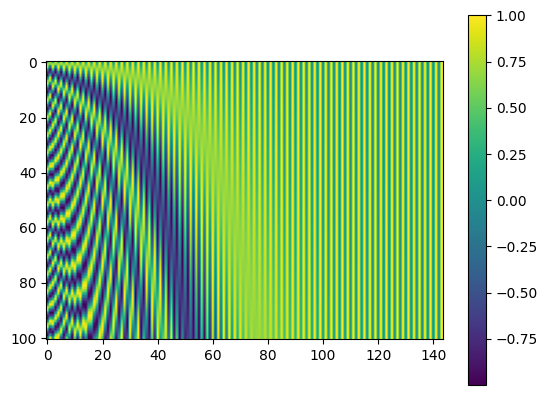

In [12]:
import math
import torch
import matplotlib.pyplot as plt

def rel_pos_embeddings(max_rel_pos, embed_dim):
    rel_pos_tensor = torch.zeros(2*max_rel_pos+1, embed_dim)
    pos = torch.arange(0, 2*max_rel_pos+1).unsqueeze(1).float()
    divisor = torch.exp(torch.arange(0,embed_dim,2).float()*-math.log(10000)/embed_dim)
    rel_pos_tensor[:, 0::2] = torch.sin(pos*divisor)
    rel_pos_tensor[:, 1::2] = torch.cos(pos*divisor)
    final_pos_tensor = rel_pos_tensor.unsqueeze(0)
    return final_pos_tensor


max_rel_pos = 50
embed_dim = 144

rel_pos_embedding = rel_pos_embeddings(max_rel_pos, embed_dim)
print(rel_pos_embedding.shape)


#  display
draw = rel_pos_embedding.squeeze().numpy()
plt.imshow(draw, cmap='viridis')
plt.colorbar()
plt.show()


In [17]:
seq_len = 600
batch_dim = 16

rel_pos = torch.arange(seq_len).unsqueeze(0).expand(batch_dim, seq_len)
print(rel_pos.shape) # [16, 600]


rel_pos_embedding[:, :, :].shape

torch.Size([16, 600])


torch.Size([1, 101, 144])

In [2]:
import torch
import torch.nn as nn

use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)



cuda


In [4]:

x = torch.randn(2,2).to(device)
x1 = x[1,1]

x1

tensor(-0.6380, device='cuda:0')

In [7]:
st = "train-clean-100"
st = "train-clean-260"

st[:5]

'train'

In [6]:
from models.conformer.blocks import Prolog, ConformerMHSA, ConformerConv, ConformerFFN, ConvSubsampling
from models.conformer.conformer import Conformer, ConformerBlock
import torch
import torch.nn as nn

use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [7]:

seq_len = 800
num_features = 128
encoder_dim = 144
batch = 16

x = torch.randn(batch, 1, seq_len, num_features).to(device)


In [8]:
x.shape

torch.Size([16, 1, 800, 128])

In [4]:

# layers
#sub = ConvSubsampling(out_channels=128).to(device)
prol = Prolog(in_features=num_features, encoder_dim=256).to(device)
#ffn_1 = ConformerFFN(encoder_dim=encoder_dim).to(device)
#mhsa = ConformerMHSA(emb_dim=encoder_dim, device=device).to(device)
#conv = ConformerConv(num_features=encoder_dim).to(device)
#ffn_2 = ConformerFFN(num_features=encoder_dim).to(device)
#conf_block = ConformerBlock(encoder_dim=144, device=device).to(device)
#lstm = nn.LSTM(input_size=144,
#                            hidden_size=320,
#                            num_layers=1,
#                            batch_first=True).to(device)

# pipeline
x = prol(x)
#x = conf_block(x)
#x, _ = lstm(x)
#x = ffn_1(x)
#x = mhsa(x)
#x = conv(x)
# x = ffn_2(x)

print(f"{x.shape}")

torch.Size([16, 400, 256])


In [9]:
# layers
conf = Conformer(in_features=128,
                 encoder_dim=256,
                 num_heads=4,
                 kernel_size=31,
                 hidden_size=320,
                 n_class=29,
                 n_blocks=16,
                 device=device).to(device)

# pipeline
x = conf(x)
print(f"{x.shape}")

torch.Size([16, 400, 29])
